# Baseline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [22]:
df = pd.read_csv('df_with_target_and_features.csv', sep='\t')
df.shape

(7781619, 57)

In [5]:
df.head()

period  product_id  customer_id         tn     target  cat1_FOODS  \
0  2017-01       20001        10001   99.43861   92.46537         0.0   
1  2017-02       20001        10001  198.84365   13.29728         0.0   
2  2017-03       20001        10001   92.46537  101.00563         0.0   
3  2017-04       20001        10001   13.29728  128.04792         0.0   
4  2017-05       20001        10001  101.00563  101.20711         0.0   

   cat1_HC  cat1_PC  cat1_REF    tn_lag1  ...  share_cliente  prod_start  \
0      1.0      0.0       0.0        NaN  ...       0.052969     2017-01   
1      1.0      0.0       0.0   99.43861  ...       0.085162     2017-01   
2      1.0      0.0       0.0  198.84365  ...       0.032619     2017-01   
3      1.0      0.0       0.0   92.46537  ...       0.005350     2017-01   
4      1.0      0.0       0.0   13.29728  ...       0.036501     2017-01   

   cust_start  prod_age  cust_age  no_sale  no_sale_streak  tn_slope3  \
0     2017-01         0         0        0               0        NaN   
1     2017-01         1         1        0               0  99.405040   
2     2017-01         2         2        0               0  -3.486620   
3     2017-01         3         3        0               0 -92.773185   
4     2017-01         4         4        0               0   4.270130   

   tn_slope6  tn_slope12  
0        NaN         NaN  
1  99.405040   99.405040  
2  -3.486620   -3.486620  
3 -36.480227  -36.480227  
4 -18.241233  -18.241233  

[5 rows x 57 columns]

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# — Supuestos —
# • df: DataFrame con al menos columnas ['periodo','product_id','customer_id','tn']
#   donde 'periodo' es string "YYYY-MM" y 'tn' es toneladas vendidas ese mes-cliente.
# • Queremos pronosticar para febrero 2020 (2020-02) cada product_id.

# 1) Convertir 'periodo' a PeriodIndex mensual
df = df.copy()
df['period'] = pd.to_datetime(df['period'], format='%Y-%m').dt.to_period('M')

In [7]:
# 2) Agrupar ventas por product_id y mes, sumando sobre clientes
ventas_por_sku = (
    df
    .groupby(['product_id','period'])['tn']
    .sum()
    .reset_index()
)

In [8]:
# 3) Construir un DataFrame de destino para guardar todas las predicciones
predicciones = []

# 4) Iterar sobre cada producto único
for sku in ventas_por_sku['product_id'].unique():
    # 4.1) Filtrar solo las filas de este SKU
    df_sku = ventas_por_sku[ventas_por_sku['product_id'] == sku].copy()
    
    # 4.2) Establecer el índice como 'period' y extraer la serie de tn
    df_sku.set_index('period', inplace=True)
    serie = df_sku['tn'].sort_index()
    
    # 4.3) Completar cualquier mes faltante con 0 (asegurarse de tener todos los meses hasta 2019-12)
    #      Definimos el rango desde el primer mes observado hasta 2019-12
    primer_mes = serie.index.min()
    ultimo_mes  = pd.Period('2019-12', freq='M')
    full_index  = pd.period_range(primer_mes, ultimo_mes, freq='M')
    serie = serie.reindex(full_index, fill_value=0)
    
    # 4.4) Ajustar ARIMA. Usamos (1,1,1) como ejemplo; puedes cambiar el orden si lo deseas.
    try:
        modelo = ARIMA(serie, order=(1, 1, 1))
        resultado = modelo.fit()
        
        # 4.5) Forecast de 2 pasos: enero 2020 y febrero 2020
        forecast = resultado.get_forecast(steps=2)
        forecast_index = pd.period_range(ultimo_mes + 1, periods=2, freq='M')
        
        # 4.6) Extraer solo la predicción de febrero 2020 (paso 2)
        tn_pred_feb = float(forecast.predicted_mean.iloc[1])  # índice 1 → t+2
        
        # 4.7) Guardar en la lista de resultados
        predicciones.append({
            'product_id': sku,
            'period':      pd.Period('2020-02', freq='M'),
            'tn_pred':     tn_pred_feb
        })
    except Exception as e:
        # Si falla el ajuste (p.ej., serie muy corta), asignar NaN o 0
        predicciones.append({
            'product_id': sku,
            'period':      pd.Period('2020-02', freq='M'),
            'tn_pred':     np.nan
        })
        continue


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

In [9]:
# 5) Concatenar todos los resultados en un DataFrame
df_preds_arima = pd.DataFrame(predicciones)

# 6) (Opcional) Convertir 'period' a string 'YYYY-MM' y quedarnos solo con febrero 2020
df_preds_arima['periodo'] = df_preds_arima['period'].dt.strftime('%Y-%m')
df_preds_arima = df_preds_arima[['product_id','periodo','tn_pred']]

# 7) Mostrar un ejemplo de las primeras filas
print(df_preds_arima.head(10))

   product_id  periodo      tn_pred
0       20001  2020-02  1488.803766
1       20002  2020-02  1237.546628
2       20003  2020-02   881.870603
3       20004  2020-02   655.590501
4       20005  2020-02   621.425943
5       20006  2020-02   447.263522
6       20007  2020-02   391.649870
7       20008  2020-02   342.557178
8       20009  2020-02   571.252393
9       20010  2020-02   419.893304


In [10]:
# 8) Si deseas exportar a CSV (una línea por product_id con tn_pred de 2020-02):
df_entrega_arima = df_preds_arima.groupby('product_id', as_index=False)['tn_pred'].sum()
df_entrega_arima.columns = ['product_id','prediccion_feb2020']
df_entrega_arima.to_csv('prediccion_arima_feb2020.csv', index=False)

# ARIMA CON ESTACIONALIDAD

In [23]:
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# — Supuestos —
# • df: DataFrame con al menos columnas ['periodo','product_id','customer_id','tn']  
#   donde 'periodo' es string "YYYY-MM" y 'tn' son toneladas vendidas ese mes-cliente.  
# • Queremos pronosticar febrero 2020 (t+2) para cada SKU, usando SARIMA con m=12.  

# 1) Convertir 'periodo' a PeriodIndex mensual
df = df.copy()
df['period'] = pd.to_datetime(df['period'], format='%Y-%m').dt.to_period('M')

# 2) Agregar toneladas por SKU y mes (sumando sobre clientes)
ventas_por_sku = (
    df
    .groupby(['product_id','period'])['tn']
    .sum()
    .reset_index()
)

# 3) Listado donde guardaremos resultados
resultados = []

# 4) Iterar sobre cada SKU
for sku in ventas_por_sku['product_id'].unique():
    # 4.1) Filtrar solo las filas de este SKU
    df_sku = ventas_por_sku[ventas_por_sku['product_id'] == sku].copy()
    
    # 4.2) Poner 'period' como índice y extraer la serie de tn
    df_sku.set_index('period', inplace=True)
    serie = df_sku['tn'].sort_index()
    
    # 4.3) Rellenar meses faltantes con cero hasta 2019-12
    primer_mes = serie.index.min()
    ultimo_mes  = pd.Period('2019-12', freq='M')
    full_index  = pd.period_range(primer_mes, ultimo_mes, freq='M')
    serie = serie.reindex(full_index, fill_value=0)
    
    # 4.4) Usar auto_arima para buscar automáticamente un SARIMA(p,d,q)(P,D,Q,12)
    #      Si la serie es muy corta, force D=0 o fallback a ARIMA simple.
    try:
        modelo_auto = pm.auto_arima(
            serie,
            start_p=0, max_p=3,
            start_q=0, max_q=3,
            d=None,
            seasonal=True, m=12,
            start_P=0, max_P=1,
            start_Q=0, max_Q=1,
            D=None,              # que elija D automáticamente
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        order = modelo_auto.order
        seasonal_order = modelo_auto.seasonal_order  # (P,D,Q,12)
    except Exception:
        # Si auto_arima falla (serie muy corta), recurrimos a un SARIMA básico sin diferenciación estacional:
        order = (1, 1, 1)
        seasonal_order = (0, 0, 0, 12)
    
    # 4.5) Ajustar SARIMAX con los parámetros hallados
    try:
        modelo_sarima = SARIMAX(
            serie,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        
        # 4.6) Forecast de 2 pasos (ene-2020 y feb-2020)
        fc = modelo_sarima.get_forecast(steps=2)
        tn_pred_feb2020 = float(fc.predicted_mean.iloc[1])
    except Exception:
        tn_pred_feb2020 = np.nan
    
    resultados.append({
        'product_id': sku,
        'tn_pred':    tn_pred_feb2020
    })

# 5) Crear DataFrame final
df_preds_arima = pd.DataFrame(resultados)

# 6) Mostrar primeras filas
print(df_preds_arima.head(10))

# 7) Exportar (opcional)
df_preds_arima.to_csv('prediccion_sarima_feb2020_estacionalidad.csv', index=False)


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: '

   product_id      tn_pred
0       20001  1488.310799
1       20002  1192.121011
2       20003   844.475674
3       20004   642.699899
4       20005   545.337325
5       20006   426.280189
6       20007   390.762151
7       20008   308.959168
8       20009   572.508538
9       20010   308.903267


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: '

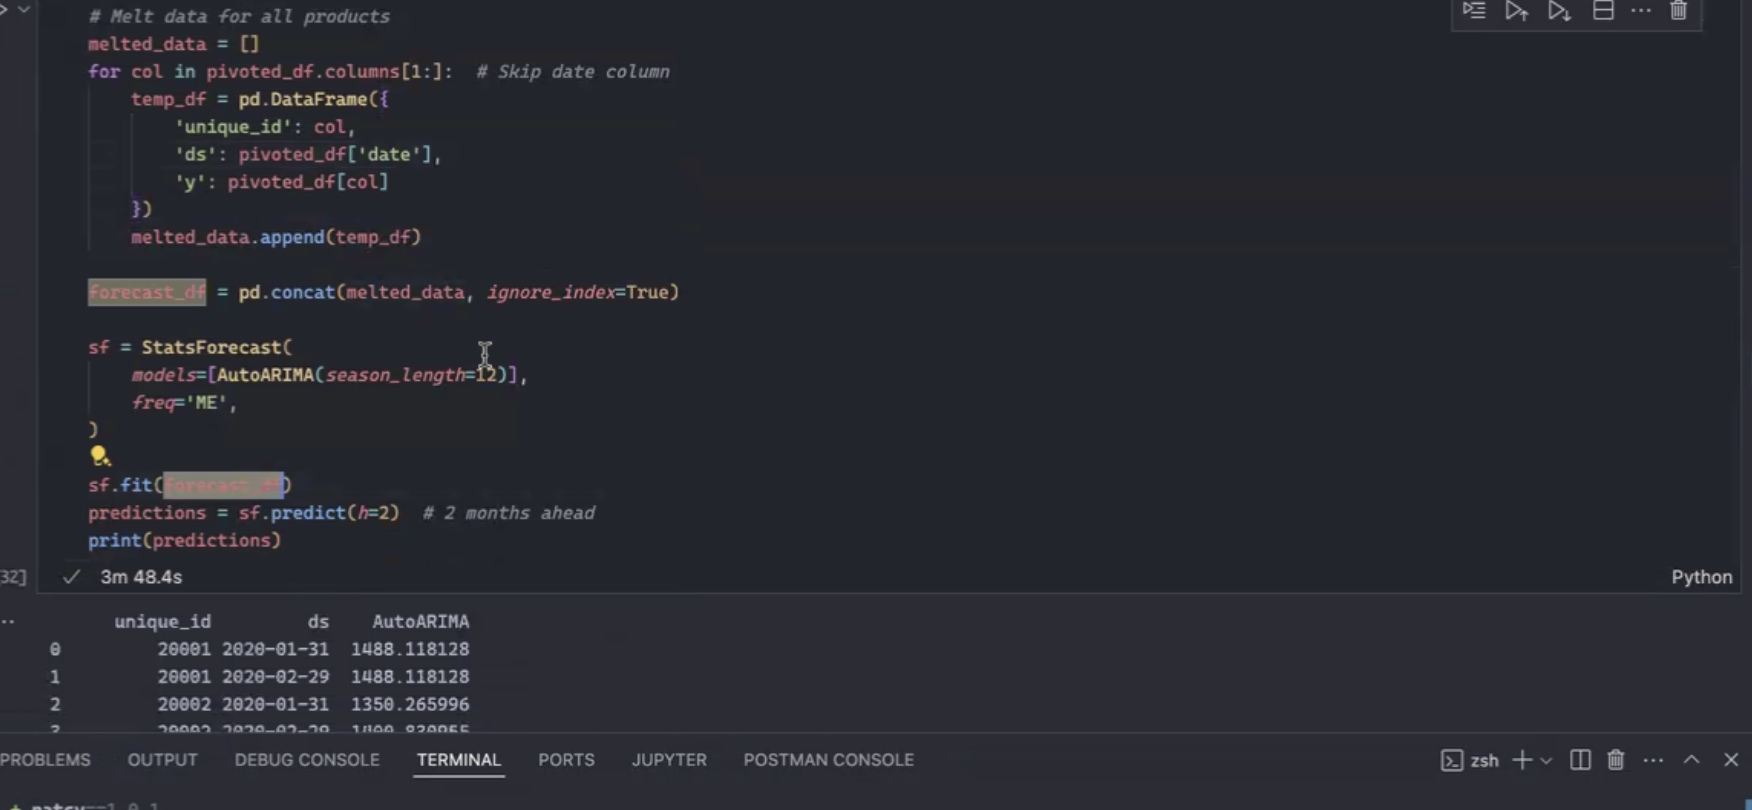

# AUTOARIMA

In [19]:
import pandas as pd
import numpy as np
import pmdarima as pm

# — Supuestos —
# • df: DataFrame original con columnas ['periodo','product_id','customer_id','tn']
#   donde 'periodo' es string "YYYY-MM" e 'tn' es toneladas vendidas ese mes-cliente.
# • Queremos obtener un DataFrame final con columnas ['product_id','tn_pred'] para febrero 2020,
#   usando auto_arima para seleccionar el mejor ARIMA(p,d,q)(P,D,Q,12).

# 1) Convertir 'periodo' a PeriodIndex mensual
df = df.copy()
df['period'] = pd.to_datetime(df['period'], format='%Y-%m').dt.to_period('M')

# 2) Agregar toneladas por SKU y mes, sumando sobre clientes
ventas_por_sku = (
    df
    .groupby(['product_id','period'])['tn']
    .sum()
    .reset_index()
)

# 3) Preparamos la lista donde guardaremos resultados
resultados = []

# 4) Iteramos sobre cada product_id único
for sku in ventas_por_sku['product_id'].unique():
    # 4.1) Filtrar las filas de este SKU
    df_sku = ventas_por_sku[ventas_por_sku['product_id'] == sku].copy()
    
    # 4.2) Establecer índice como 'period' y extraer la serie de tn
    df_sku.set_index('period', inplace=True)
    serie = df_sku['tn'].sort_index()
    
    # 4.3) Rellenar meses faltantes con cero hasta 2019-12
    primer_mes = serie.index.min()
    ultimo_mes  = pd.Period('2019-12', freq='M')
    full_index  = pd.period_range(primer_mes, ultimo_mes, freq='M')
    serie = serie.reindex(full_index, fill_value=0)
    
    # 4.4) Llamar a auto_arima para encontrar el mejor modelo SARIMA/ARIMA
    #      Forzamos D=0 para evitar el error de diferenciación estacional si la serie es corta
    try:
        modelo_auto = pm.auto_arima(
            serie,
            start_p=0, max_p=3,
            start_q=0, max_q=3,
            d=None,
            seasonal=True, m=12,
            start_P=0, max_P=1,
            start_Q=0, max_Q=1,
            D=0,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        
        # 4.5) Predecir 2 pasos adelante (ene-2020 y feb-2020)
        fc = modelo_auto.predict(n_periods=2)
        tn_pred_feb2020 = float(fc[1])  # posición 1 → febrero 2020
    except Exception:
        # Si algo falla, asignamos NaN
        tn_pred_feb2020 = np.nan
    
    # 4.6) Guardar el resultado para este SKU
    resultados.append({
        'product_id': sku,
        'tn_pred':    tn_pred_feb2020
    })

# 5) Construir el DataFrame final
df_preds_arima = pd.DataFrame(resultados)

# 6) Mostrar las primeras filas
print(df_preds_arima.head(10))

# 7) (Opcional) Exportar a CSV
df_preds_arima.to_csv('prediccion_arima_feb2020_por_sku.csv', index=False)

/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: '

   product_id      tn_pred
0       20001  1488.554631
1       20002  1259.893644
2       20003   845.472156
3       20004   640.684992
4       20005   565.031116
5       20006   422.253256
6       20007   405.896239
7       20008   397.333078
8       20009   572.465401
9       20010   464.783146


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/c5/g8wp4j8j1nd226rj0lw9_vz40000gn/T/ipykernel_41725/977327971.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tn_pred_feb2020 = float(fc[1])  # posición 1 → febrero 2020


In [14]:
import pmdarima as pm

modelo_auto = pm.auto_arima(
    serie,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,                # déjalo elegir d (I)
    seasonal=True,         # permitirle buscar términos estacionales
    m=12,                  # período estacional de 12 meses
    start_P=0, max_P=1,    # limitar búsqueda de P (para evitar D=1 si la serie es muy corta)
    start_Q=0, max_Q=1,
    D=0,                   # forzar que D=0 (no diferenciar estacionalmente)
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(modelo_auto.summary())

/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: '

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-31.320, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-25.408, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-29.320, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-29.320, Time=0.04 sec


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: Runtim

 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-27.320, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-38.494, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-37.381, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-38.438, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-38.480, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-36.394, Time=0.09 sec


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: '

 ARIMA(1,0,0)(0,0,0)[12]             : AIC=-39.247, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=inf, Time=0.16 sec


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12]             : AIC=inf, Time=0.13 sec


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12]             : AIC=-35.489, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=-38.905, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12]             : AIC=-39.352, Time=0.03 sec


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[12]             : AIC=-37.640, Time=0.16 sec
 ARIMA(1,0,1)(0,0,1)[12]             : AIC=inf, Time=0.19 sec


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12]             : AIC=-35.640, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12]             : AIC=-37.371, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[12]             : AIC=-37.368, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[12]             : AIC=inf, Time=0.05 sec


/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: '

 ARIMA(2,0,2)(0,0,0)[12]             : AIC=-35.373, Time=0.08 sec

Best model:  ARIMA(1,0,1)(0,0,0)[12]          
Total fit time: 3.314 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  22.676
Date:                Tue, 03 Jun 2025   AIC                            -39.352
Time:                        20:34:15   BIC                            -38.444
Sample:                    03-31-2019   HQIC                           -40.348
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8970      0.152      5.899      0.000       0.599

In [15]:
n_pred = 2  # t+1 (ene-2020) y t+2 (feb-2020)
fc = modelo_auto.predict(n_periods=n_pred, return_conf_int=False)
tn_pred_feb2020 = fc[-1]  # segundo elemento del array

/Users/indianaabeledo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/c5/g8wp4j8j1nd226rj0lw9_vz40000gn/T/ipykernel_41725/2564902035.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tn_pred_feb2020 = fc[-1]  # segundo elemento del array


In [ ]:
optimizacion por lasso o rich L1 L2
optimizacion bayesiana
